# 3 Multiple Monte Carlo Processes

$$
dX_t = 0.01 X_t dt + 0.3 X_t dW_t^1, \quad X_0 = 80\\
dY_t = 100(90000 + 1000t -Y_t)dt + \sqrt{Y_t}dW_t^2,\quad Y_0=90000\\
dZ_t = 5(6-Z_t) + 0.01\sqrt{Z_t} dW_t^3,\quad Z_0 = 6.1
$$

In [3]:
import numpy as np
import scipy as sp
import scipy.stats
from cvxopt import matrix, solvers
import pandas as pd

In [108]:
# X
risk_free_rate = 0.01
dividend = 0
volatility = 0.3
X0 = 80

# Y
Y0 = 90000
kappaY = 100
thetaY = 90000
theta1Y = 1000
xiY = 1

# Z
Z0 = 6.1
kappaZ = 5
thetaZ = 6
xiZ = 0.01

T = 10/252
n_trials = 3000000
n_steps = 40

In [105]:
class MonteCarloEngine:
    def __init__(self,S0=100,T=1,r=0,q=0,sigma=0,kappa=0,theta=0,theta1=0,xi=0,rho=0,V0=0,underlying_process="geometric brownian motion"):
        self.underlying_process = underlying_process
        self.S0 = S0
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.theta1 = theta1
        self.rho = rho
        self.V0 = V0
        self.xi = xi
        
        self.value_results = None
    
    # view antithetic variates as a option of simulation method to reduce the variance    
    def simulate(self, n_trails, n_steps, antitheticVariates=False, boundaryScheme="Higham and Mao"):
        
        dt = self.T/n_steps
        mu = self.r - self.q
        self.n_trails = n_trails
        self.n_steps = n_steps
        self.boundaryScheme = boundaryScheme
        
        if(self.underlying_process=="geometric brownian motion"):
#             first_step_prices = np.ones((n_trails,1))*np.log(self.S0)
            log_price_matrix = np.zeros((n_trails,n_steps))
            normal_matrix = np.random.normal(size=(n_trails,n_steps))
            if(antitheticVariates==True):
                n_trails *= 2
                self.n_trails = n_trails
                normal_matrix = np.concatenate((normal_matrix,-normal_matrix),axis=0)
            cumsum_normal_matrix = normal_matrix.cumsum(axis=1)
#             log_price_matrix = np.concatenate((first_step_prices,log_price_matrix),axis=1)
            deviation_matrix = cumsum_normal_matrix*self.sigma*np.sqrt(dt) + \
    (mu-self.sigma**2/2)*dt*np.arange(1,n_steps+1)
            log_price_matrix = deviation_matrix+np.log(self.S0)
            price_matrix = np.exp(log_price_matrix)
            price_zero = (np.ones(n_trails)*self.S0)[:,np.newaxis]
            price_matrix = np.concatenate((price_zero,price_matrix),axis=1)
            self.price_matrix = price_matrix
        
        elif(self.underlying_process=="CIR model"):
            # generate correlated random variables
            randn_matrix_v = np.random.normal(size=(n_trails,n_steps))
            if(antitheticVariates==True):
                n_trails *= 2
                self.n_trails = n_trails
                randn_matrix_v = np.concatenate(( randn_matrix_v, -randn_matrix_v),axis=0)

            # boundary scheme fuctions
            if(boundaryScheme=="absorption"):
                f1=f2=f3=lambda x: np.maximum(x,0)
            elif(boundaryScheme=="reflection"):
                f1=f2=f3=np.absolute
            elif(boundaryScheme=="Higham and Mao"):
                f1=f2=lambda x: x
                f3 = np.absolute
            elif(boundaryScheme=="partial truncation"):
                f1=f2=lambda x: x
                f3=lambda x: np.maximum(x,0)
            elif(boundaryScheme=="full truncation"):
                f1 = lambda x: x
                f2=f3= lambda x: np.maximum(x,0)
            
            # simulate CIR process
            V_matrix = np.zeros((n_trails,n_steps+1))
            V_matrix[:,0] = self.S0

            for j in range(self.n_steps):
                V_matrix[:,j+1] = f1(V_matrix[:,j]) - self.kappa*dt*(f2(V_matrix[:,j])-self.theta-self.theta1*dt*j) +\
                    self.xi*np.sqrt(f3(V_matrix[:,j]))*np.sqrt(dt)*randn_matrix_v[:,j]
                V_matrix[:,j+1] = f3(V_matrix[:,j+1])
                
            price_matrix = V_matrix
            self.price_matrix = price_matrix
            
        
        elif(self.underlying_process=="Heston model"):
            # generate correlated random variables
            randn_matrix_1 = np.random.normal(size=(n_trails,n_steps))
            randn_matrix_2 = np.random.normal(size=(n_trails,n_steps))
            randn_matrix_v = randn_matrix_1
            randn_matrix_S = self.rho*randn_matrix_1 + np.sqrt(1-self.rho**2)*randn_matrix_2
            if(antitheticVariates==True):
                n_trails *= 2
                self.n_trails = n_trails
                randn_matrix_v = np.concatenate(( randn_matrix_v, +randn_matrix_v),axis=0)
                randn_matrix_S = np.concatenate(( randn_matrix_S, -randn_matrix_S),axis=0)

            # boundary scheme fuctions
            if(boundaryScheme=="absorption"):
                f1=f2=f3=lambda x: np.maximum(x,0)
            elif(boundaryScheme=="reflection"):
                f1=f2=f3=np.absolute
            elif(boundaryScheme=="Higham and Mao"):
                f1=f2=lambda x: x
                f3 = np.absolute
            elif(boundaryScheme=="partial truncation"):
                f1=f2=lambda x: x
                f3=lambda x: np.maximum(x,0)
            elif(boundaryScheme=="full truncation"):
                f1 = lambda x: x
                f2=f3= lambda x: np.maximum(x,0)
            
            # simulate stochastic volatility process
            V_matrix = np.zeros((n_trails,n_steps+1))
            V_matrix[:,0] = self.V0
            log_price_matrix = np.zeros((n_trails,n_steps+1))
            log_price_matrix[:,0] = np.log(self.S0)
            for j in range(self.n_steps):
#                 V_matrix[:,j+1] = self.kappa*self.theta*dt + (1-self.kappa*dt)*V_matrix[:,j] +\
#                     self.xi*np.sqrt(V_matrix[:,j]*dt)*randn_matrix_v[:,j]
                V_matrix[:,j+1] = f1(V_matrix[:,j]) - self.kappa*dt*(f2(V_matrix[:,j])-self.theta) +\
                    self.xi*np.sqrt(f3(V_matrix[:,j]))*np.sqrt(dt)*randn_matrix_v[:,j]
                V_matrix[:,j+1] = f3(V_matrix[:,j+1])
                log_price_matrix[:,j+1] = log_price_matrix[:,j] + (mu - V_matrix[:,j]/2)*dt +\
                    np.sqrt(V_matrix[:,j]*dt)*randn_matrix_S[:,j]
            price_matrix = np.exp(log_price_matrix)
            self.price_matrix = price_matrix
            
        return price_matrix
    

In [109]:
mc_X = MonteCarloEngine(S0=X0,T=T,r=risk_free_rate,q=0,sigma=volatility)
mc_Y = MonteCarloEngine(S0=Y0,T=T,kappa=kappaY,theta=thetaY,theta1=theta1Y,xi=xi,underlying_process="CIR model")
mc_Z = MonteCarloEngine(S0=Z0,T=T,kappa=kappaZ,theta=thetaZ,xi=xi,underlying_process="CIR model")

In [110]:
price_matrix_X = mc_X.simulate(n_trails=n_trials,n_steps=n_steps)
price_matrix_Y = mc_Y.simulate(n_trails=n_trials,n_steps=n_steps,boundaryScheme="Higham and Mao")
price_matrix_Z = mc_Z.simulate(n_trails=n_trials,n_steps=n_steps,boundaryScheme="Higham and Mao")

### 1. Calculate the number of shares and the amount in Yuan that the portfolio contains when it is started.

$$
nShares = \frac{10m \times 40\%}{X_0} = 0.05m = 50000\\
nTBills = \frac{10m \times 30\%}{90000} = \frac{100}{3}\\
nCNY = 10m \times 30\% \times Z_0 = 18300000
$$

### 2. Assume the Brownian motions are independent and perform Monte Carlo simulations for all assets for 10 days (t = 10/252). Use 3 million simulations, and use $\Delta t = 0.001$. Calculate VAR for the portfolio ($\alpha = 0.01$, N = 10 days).

Since T=10/252 cannot perfectly divided by $\Delta t=0.001$, set number of trials as
$$N_s = \lceil\frac{T}{\Delta t}\rceil = 40$$

There are two ways to calculate value at risk, one is empirical method, the other is using calibrated distribution. Here we use the latter strategy: using normal distribution to fit the distribution.

### 3. Calculate the CVAR (conditional value at risk).
CVaR equals to the average returns under the $VaR(\alpha)$

In [111]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [144]:
def calc_VaR(x,alpha):
    mu = np.mean(x)
    sigma = np.std(x)
    num_bins = 50

    # the histogram of the data
    n, bins, patches = plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
    # add a 'best fit' line
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--')
    plt.xlabel('Smarts')
    plt.ylabel('Probability')
    
    VaR = sp.stats.norm.ppf(alpha,loc=mu,scale=sigma)
    plt.axvline(x=VaR, color='k', linestyle='--')
    CVaR = x[x<VaR].mean()
    print("expected return: {:f}".format(x.mean()))
    print("{}% Value at Risk: {:f}".format((1-alpha)*100,VaR))
    print("{}% Conditional Value at Risk: {:f}".format((1-alpha)*100,CVaR))

expected return: 0.001746
99.0% Value at Risk: -0.062291
99.0% Conditional Value at Risk: -0.070220


D:\Softwares\Anaconda3\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\Softwares\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


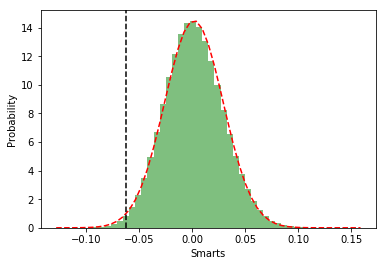

In [145]:
alpha=0.01
portfolio_value = price_matrix_X[:,-1]*50000 + price_matrix_Y[:,-1]*100/3 + 18.3e6/price_matrix_Z[:,-1]
portfolio_return = portfolio_value/1e7 - 1
calc_VaR(portfolio_return,alpha)

In [70]:
mc.BSDeltaHedgedPricer()

6.887722106237097